In [39]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۲ — مبانی داده و پیش‌پردازش
## درس ۱۱: کُدگذاری ویژگی‌های رده‌ای (One-Hot، Ordinal، Hashing، Target Encoding)

### در این درس چه چیزهایی یاد می‌گیرید
در پایان این درس، قادر خواهید بود:

1. تشخیص دهید *کدام* ویژگی‌های رده‌ای نیاز به کُدگذاری دارند و *چرا* اغلب برآوردگرهای یادگیری ماشین نمی‌توانند رشته‌های خام را مصرف کنند.
2. چهار روش رایج **one-hot**، **ordinal**، **hashing** و **target encoding** را پیاده‌سازی و مقایسه کنید.
3. دربارهٔ **مبادله‌های آماری و محاسباتی** (بُعد، تُنُکی، برخوردهای هش، بایاس/واریانس و خطر نشت اطلاعات) استدلال کنید.
4. خط لوله‌های پیش‌پردازش **قابل‌استفاده در تولید** با `ColumnTransformer` و `Pipeline` بسازید، به‌همراه مدیریت امنِ دسته‌های دیده‌نشده.
5. **Target encoding بدون نشت** را با استفاده از آمارِ خارج از فولد (out-of-fold) اجرا کنید.

در طول درس، از چندین دیتاست موجود در مخزن استفاده می‌کنیم که با مسیرهای نسبی بارگذاری می‌شوند.


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, Ridge, SGDClassifier
from sklearn.feature_extraction import FeatureHasher

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)


---

## ۱. چرا کُدگذاری ویژگی‌های رده‌ای یک کار تزئینی نیست؟

یک ویژگی رده‌ای (categorical) مقادیر خود را از یک **مجموعهٔ متناهی** می‌گیرد:
$$
x \in \mathcal{C}=\{c_1,\dots,c_K\}.
$$

بیشتر الگوریتم‌های یادگیری ماشین روی بردارهایی در $\mathbb{R}^d$ کار می‌کنند و به عملیات جبری (ضرب داخلی، گرادیان، فاصله) متکی‌اند. دسته‌های خام (رشته‌ها) **حسابِ متعارف** ندارند:
- تعریف معناداری برای $c_i + c_j$ یا $2\cdot c_i$ وجود ندارد.
- حتی اگر دسته‌ها را به اعداد صحیح نگاشت کنید، مگر آن‌که دسته‌ها واقعاً مرتب باشند، این نگاشت یک **هندسهٔ مصنوعی** ایجاد می‌کند.

پس کُدگذاری در اصل یک انتخابِ نمایش (representation) است:
$$
\phi:\mathcal{C}\rightarrow \mathbb{R}^d,\quad \text{و ما روی } \phi(x)\text{ یاد می‌گیریم}.
$$

یک کُدگذاری خوب باید:
- ساختار *مرتبط* را حفظ کند (مثلاً ترتیب وقتی واقعاً وجود دارد)،
- از تزریق ساختار *غلط* جلوگیری کند (مثلاً فاصله‌های مصنوعیِ ناشی از اعداد دلخواه)،
- نسبت به *دسته‌های جدید/دیده‌نشده* مقاوم باشد،
- بُعد و مصرف حافظه را کنترل کند،
- و (در target encoding) از **نشت اطلاعات** جلوگیری کند.

در این درس چهار خانوادهٔ استاندارد را بررسی می‌کنیم:
1. one-hot encoding
2. ordinal encoding
3. hashing (feature hashing / hashing trick)
4. target encoding (mean encoding) به‌همراه نسخه‌های امن در برابر نشت


## ۲. رده‌بندی ویژگی‌های رده‌ای: اسمی، ترتیبی، و با کاردینالیتهٔ بالا

ویژگی‌های رده‌ای معمولاً در چند شکل ظاهر می‌شوند:

### اسمی (Nominal؛ بدون ترتیب)
مثال: `Sex ∈ {M,F}` یا `Color ∈ {Red, Blue, ...}`.
اینجا **هیچ ترتیبی** وجود ندارد. کُدگذاری نباید القا کند که یک دسته «بزرگ‌تر» است.

### ترتیبی (Ordinal؛ دارای ترتیب)
مثال: سطح تحصیلات یا رتبه‌ها (`low < medium < high`) یا مقیاس‌هایی که در دامنه تعریف شده‌اند.
در این حالت ترتیب معنادار است و کُدگذاری می‌تواند از این ساختار استفاده کند.

### اسمی با کاردینالیتهٔ بالا (High-cardinality)
مثال: شناسهٔ محصول، شناسهٔ کاربر، نام شهرها، یا دسته‌بندی‌های آزاد.
اگر $K$ (تعداد دسته‌های یکتا) بزرگ باشد، one-hot ممکن است از نظر محاسباتی سنگین شود چون فضای بسیار پُربُعد و تُنُک می‌سازد.

یک خلاصهٔ کاربردی:

| نوع | $K$ معمول | کاندیدهای کُدگذاری | ریسک اصلی |
|---|---:|---|---|
| اسمی | کم تا متوسط | one-hot | انفجار بُعد در کاردینالیتهٔ بالا |
| ترتیبی | کم تا متوسط | ordinal (با ترتیب صریح) | ترتیب غلط اگر حدس بزنید |
| اسمیِ پرکاردینال | زیاد | hashing، target encoding | برخورد (hashing)، نشت (target) |

در ادامه، هر روش را روی دیتاست‌های واقعی پیاده‌سازی می‌کنیم.


---

## ۳. One-hot encoding: انتخاب پیش‌فرض برای دسته‌های اسمی

### تعریف
برای مجموعهٔ دسته‌ها $\mathcal{C}=\{c_1,\dots,c_K\}$، one-hot نگاشت می‌کند:
$$
\phi(c_k) = e_k \in \mathbb{R}^K
$$
که در آن $e_k$ بردار پایهٔ استاندارد (۱ در مؤلفهٔ $k$ و ۰ در بقیه) است.

اگر یک نمونه چندین فیلد رده‌ای داشته باشد، one-hot برای هر فیلد جداگانه انجام می‌شود و سپس الحاق (concatenate) می‌گردد.

### تلهٔ متغیر ساختگی (dummy-variable trap) و شناسایی‌پذیری
در مدل‌های خطی با بایاس (intercept)، ستون‌های one-hot برای یک ویژگی به‌صورت خطی وابسته‌اند:
$$
\sum_{k=1}^{K} e_k = \mathbf{1}.
$$
یک راه رایج این است که یک دسته را حذف کنید (reference coding) یا به منظم‌سازی تکیه کنید.
در scikit-learn، گزینهٔ `OneHotEncoder(drop="first")` یک سطح را برای هر ویژگی حذف می‌کند.

### چه زمانی خوب کار می‌کند؟
- دسته‌های اسمی با $K$ کم تا متوسط
- مدل‌های خطی/GLM که از نمایش تُنُکِ پُربُعد سود می‌برند
- بسیاری از مدل‌ها ماتریس‌های تُنُک را کارآمد پردازش می‌کنند (مثلاً logistic regression با حل‌گر `saga`)

کار را با دیتاست `drug200.csv` شروع می‌کنیم (پیش‌بین‌های رده‌ای مانند `Sex`، `BP` و `Cholesterol`).


In [3]:
path_drug = "../../../Datasets/Classification/drug200.csv"
drug = pd.read_csv(path_drug)
drug.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
drug.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


### ساخت یک خط لولهٔ پایه با one-hot

مراحل:
1. تقسیم داده به train/test،
2. one-hot کردن ستون‌های رده‌ای،
3. عبور دادن ستون‌های عددی بدون تغییر،
4. آموزش یک logistic regression چندکلاسه.

گزینهٔ `handle_unknown="ignore"` برای پایداری در زمان استقرار ضروری است؛ چون ممکن است در دادهٔ واقعی دستهٔ جدید ظاهر شود.


In [5]:
target = "Drug"
X = drug.drop(columns=[target])
y = drug[target]

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

cat_cols, num_cols


(['Sex', 'BP', 'Cholesterol'], ['Age', 'Na_to_K'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocess_ohe = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

clf_ohe = Pipeline(steps=[
    ("preprocess", preprocess_ohe),
    ("model", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

clf_ohe.fit(X_train, y_train)

pred = clf_ohe.predict(X_test)
acc = accuracy_score(y_test, pred)
acc


0.98

In [7]:
# بررسی فضای ویژگی پس از گسترش
ohe = clf_ohe.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

num_feature_names = np.array(num_cols, dtype=object)
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

len(all_feature_names), all_feature_names[:12]


(9,
 array(['Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL',
        'Cholesterol_HIGH', 'Cholesterol_NORMAL', 'Age', 'Na_to_K'],
       dtype=object))

### تفسیرپذیری: ضرایبِ هر دسته در مدل‌های خطی

Logistic regression ضرایبی می‌آموزد به‌طوری‌که:
$$
\log\frac{P(Y=k\mid x)}{P(Y=\text{ref}\mid x)} = \beta_k^\top \phi(x).
$$

بنابراین می‌توان دید کدام دسته‌ها پیش‌بینی را به سمت یک کلاس مشخص هل می‌دهند.


In [8]:
model = clf_ohe.named_steps["model"]
coef = pd.DataFrame(model.coef_, columns=all_feature_names, index=model.classes_)
coef.iloc[:, :15].round(3)


,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Age,Na_to_K
DrugY,-0.228,0.228,0.087,0.044,-0.132,-0.089,0.088,0.003,2.069
drugA,-0.230,0.224,1.611,-0.880,-0.737,0.092,-0.097,-0.086,-0.556
drugB,0.340,-0.334,1.461,-1.008,-0.447,-0.330,0.336,0.124,-0.379
drugC,0.021,-0.024,-0.991,1.707,-0.720,1.133,-1.136,-0.024,-0.653
drugX,0.096,-0.093,-2.169,0.137,2.035,-0.805,0.809,-0.018,-0.480


### نکات عملی برای one-hot

1. **کاردینالیتهٔ بالا**: اگر ستونی هزاران دسته داشته باشد، one-hot می‌تواند مصرف حافظه را منفجر کند.
2. **دسته‌های نادر**: دسته‌های بسیار کم‌تکرار گاهی مانند نویز رفتار می‌کنند. یک راه رایج این است که آن‌ها را به `"Other"` ادغام کنید.
3. **درخت‌ها**: برخی روش‌های درختی می‌توانند کُدهای عددی را بپذیرند، اما بسته به کتابخانه/پیکربندی، one-hot نیز می‌تواند مفید باشد.


### one-hot در قالب ماتریسی (و این‌که چرا رتبه اهمیت دارد)

فرض کنید یک ویژگی اسمی با $K$ سطح و $n$ نمونه دارید. ماتریس one-hot را با $Z\in\{0,1\}^{n\times K}$ نشان می‌دهیم که در هر سطر دقیقاً یک «۱» دارد. آنگاه:

- جمع هر سطر برابر ۱ است: $Z\mathbf{1}=\mathbf{1}$.
- اگر مدل شما ستونِ بایاس (intercept) داشته باشد، آن ستون دقیقاً یک ترکیب خطی از ستون‌های one-hot است و هم‌خطی (collinearity) ایجاد می‌کند.

یک استدلال ساده دربارهٔ رتبه:

- بدون بایاس، $\text{rank}(Z)=K$ (به شرط آن‌که هر دسته حداقل یک‌بار دیده شده باشد).
- با افزودن یک ستون بایاس، ماتریسِ ترکیبی همچنان رتبهٔ $K$ دارد ولی $K+1$ ستون دارد، پس full column rank نیست.
- اگر یک دسته را حذف کنید (reference coding)، $K-1$ ستون one-hot دارید و همراه با بایاس می‌تواند full rank شود.

در عمل، بسیاری از حل‌گرها با منظم‌سازی می‌توانند هم‌خطی را مدیریت کنند، اما صریح بودن در کُدگذاری، تفسیر و دیباگ را ساده‌تر می‌کند.


In [9]:
# نمایش رتبه/هم‌خطی روی یک ویژگی رده‌ای از drug200

Z_full = pd.get_dummies(drug["BP"], prefix="BP")  # K columns
Z_full_mat = Z_full.to_numpy()

# افزودن بایاس (intercept)
X_full = np.column_stack([np.ones(len(Z_full_mat)), Z_full_mat])

rank_Z = np.linalg.matrix_rank(Z_full_mat)
rank_X_full = np.linalg.matrix_rank(X_full)

Z_drop = pd.get_dummies(drug["BP"], prefix="BP", drop_first=True)  # K-1 columns
X_drop = np.column_stack([np.ones(len(Z_drop)), Z_drop.to_numpy()])
rank_X_drop = np.linalg.matrix_rank(X_drop)

print("تعداد دسته‌های BP:", drug["BP"].nunique())
print("رتبهٔ Z_full:", rank_Z, "ابعاد:", Z_full_mat.shape)
print("رتبهٔ [1 | Z_full]:", rank_X_full, "ابعاد:", X_full.shape)
print("رتبهٔ [1 | Z_drop_first]:", rank_X_drop, "ابعاد:", X_drop.shape)


تعداد دسته‌های BP: 3
رتبهٔ Z_full: 3 ابعاد: (200, 3)
رتبهٔ [1 | Z_full]: 3 ابعاد: (200, 4)
رتبهٔ [1 | Z_drop_first]: 3 ابعاد: (200, 3)


### one-hot با `drop="first"` و منظم‌سازی

دو الگوی رایج:

1. **Reference coding**: `OneHotEncoder(drop="first")`
   - یک سطح را برای هر ویژگی حذف می‌کند،
   - شناسایی‌پذیری را برای مدل‌های خطی با بایاس بهتر می‌کند،
   - ضرایب را نسبت به سطحِ مرجع تفسیرپذیر می‌کند.

2. **نگه‌داشتن همهٔ سطوح + منظم‌سازی**
   - ماتریس one-hot کامل را نگه دارید،
   - با جریمهٔ L2/L1 اندازهٔ ضرایب را کنترل کنید.

برای logistic regression با منظم‌سازی L2 (حالت دودویی):
$$
\min_\beta \; \sum_{i=1}^n \log\left(1+\exp(-y_i \beta^\top x_i)\right) + \lambda \lVert \beta\rVert_2^2.
$$

در ویژگی‌های تُنُک و پُربُعد، L1 یا elastic net نیز رایج است تا ضرایب تُنُک‌تر شوند.


In [10]:
# مقایسهٔ عملکرد با و بدون drop='first' روی همان مسئله (drug200)

preprocess_ohe_drop = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

clf_ohe_drop = Pipeline(steps=[
    ("preprocess", preprocess_ohe_drop),
    ("model", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

clf_ohe_drop.fit(X_train, y_train)
pred_drop = clf_ohe_drop.predict(X_test)
acc_drop = accuracy_score(y_test, pred_drop)

acc, acc_drop


(0.98, 0.98)

---

## ۴. Ordinal encoding: وقتی دسته‌ها واقعاً ترتیب دارند

### تعریف
Ordinal encoding دسته‌ها را به اعداد صحیح نگاشت می‌کند:
$$
\phi(c_k)=k \in \{1,\dots,K\}.
$$

این کار ترتیب و مفهوم فاصله را وارد می‌کند:
$$
\lvert \phi(c_i)-\phi(c_j)\rvert.
$$

### ریسک اصلی
اگر ویژگی اسمی باشد، ordinal encoding یک **تک‌سویی (monotonicity) مصنوعی** ایجاد می‌کند. بسیاری از مدل‌ها «کُد بزرگ‌تر» را «اثر بزرگ‌تر» تفسیر می‌کنند.

### کاربرد درست
وقتی دامنه یک ترتیب واقعی تعریف می‌کند و شما آن ترتیب را به‌صورت صریح وارد می‌کنید.

از دیتاست `diamonds.csv` استفاده می‌کنیم که متغیرهایی مثل `cut` و `clarity` ترتیب‌های رایج دارند.


In [11]:
path_diamonds = "../../../Datasets/Regression/diamonds.csv"
diamonds = pd.read_csv(path_diamonds)
diamonds.head()


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [12]:
diamonds[["cut","color","clarity","price","carat"]].head()


,cut,color,clarity,price,carat
0,Ideal,E,SI2,326,0.23
1,Premium,E,SI1,326,0.21
2,Good,E,VS1,327,0.23
3,Premium,I,VS2,334,0.29
4,Good,J,SI2,335,0.31


### تعریف ترتیب‌های صریح

برای نمایش، ترتیب‌های معمول زیر را مشخص می‌کنیم:

- `cut`: Fair < Good < Very Good < Premium < Ideal
- `clarity`: I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF
- `color`: D (بهترین) < E < F < G < H < I < J (بدترین)

نکتهٔ کلیدی این است که ترتیب را **شما** باید تعیین کنید، نه این‌که ترتیب الفبایی به‌صورت ضمنی تحمیل شود.


In [13]:
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
clarity_order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"]
color_order = ["D","E","F","G","H","I","J"]

diam = diamonds.sample(n=min(20000, len(diamonds)), random_state=42).copy()

X = diam.drop(columns=["price"])
y = diam["price"]

cat_cols = ["cut","color","clarity"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess_ord = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(
            categories=[cut_order, color_order, clarity_order],
            handle_unknown="use_encoded_value",
            unknown_value=-1
        ), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

reg_ord = Pipeline(steps=[
    ("preprocess", preprocess_ord),
    ("model", Ridge(alpha=1.0))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

reg_ord.fit(X_train, y_train)
pred = reg_ord.predict(X_test)

mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
(mae, r2)


(np.float64(804.1108889588803), 0.904912475392502)

### مقایسه با one-hot روی همان مسئله

one-hot هیچ فرضی دربارهٔ «فاصلهٔ خطی» بین سطوح ندارد.
Ordinal encoding فرض می‌کند فاصلهٔ بین سطوح مجاور **یکسان** است، که می‌تواند فرضِ بیش‌ازحد قوی باشد.

برای مقایسه، همان مدل رگرسیونی (Ridge) را نگه می‌داریم و فقط کُدگذاری را عوض می‌کنیم.


In [14]:
preprocess_ohe_d = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

reg_ohe = Pipeline(steps=[
    ("preprocess", preprocess_ohe_d),
    ("model", Ridge(alpha=1.0))
])

reg_ohe.fit(X_train, y_train)
pred_ohe = reg_ohe.predict(X_test)

mae_ohe = mean_absolute_error(y_test, pred_ohe)
r2_ohe = r2_score(y_test, pred_ohe)
(mae_ohe, r2_ohe)


(np.float64(728.335640540434), 0.9190160142230512)

### تفسیر

- اگر one-hot بهتر باشد، احتمالاً فرض «فاصلهٔ برابر» به مدل آسیب زده است.
- اگر ordinal تقریباً مشابه (یا بهتر) عمل کند و تعداد ویژگی‌ها کمتر باشد، نمایش کارآمدتری است.

در ادامه، به مسئلهٔ کاردینالیتهٔ بالا و روش hashing می‌پردازیم.


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

path_stars = "../../../Datasets/Classification/stars.csv"
stars = pd.read_csv(path_stars)
stars.head()


,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,Red Dwarf


In [16]:
stars["Type"].value_counts().head()


Type
Red Dwarf        40
Brown Dwarf      40
White Dwarf      40
Main Sequence    40
Super Giants     40
Name: count, dtype: int64

---

## ۴.۵ کُدگذاری و هندسه: چرا مدل‌های مبتنی بر فاصله حساس‌ترند؟

برای مدل‌های مبتنی بر فاصله (kNN، k-means، SVM با کرنل RBF)، *هندسهٔ* فضای کُدگذاری‌شده مستقیماً رفتار یادگیری را تعیین می‌کند.

### هندسهٔ one-hot
اگر دو دسته متفاوت باشند، بردارهای one-hot آن‌ها عمودند:
$$
e_i^\top e_j = 0 \quad (i\neq j),
$$
و فاصلهٔ اقلیدسیِ آن‌ها ثابت است:
$$
\lVert e_i - e_j\rVert_2 = \sqrt{2}.
$$
پس one-hot تمام عدم‌تطابق‌ها را «به یک اندازه» دور می‌بیند، که برای ویژگی‌های اسمی مناسب است.

### هندسهٔ ordinal
اگر دسته‌ها را به اعداد صحیح نگاشت کنید، فاصله به اختلاف کُدها وابسته می‌شود:
$$
\lvert \phi(c_i)-\phi(c_j)\rvert.
$$
برای ویژگی‌های اسمی، این فاصله معمولاً بی‌معناست و همسایگی‌های kNN را مخدوش می‌کند.

این اثر را با دیتاست `stars.csv` و یک طبقه‌بند kNN نشان می‌دهیم.


In [17]:
target = "Type"
X = stars.drop(columns=[target]).copy()
y = stars[target].copy()

cat_cols = ["Color", "Spectral_Class"]
num_cols = [c for c in X.columns if c not in cat_cols]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [18]:
# خط لولهٔ one-hot (خروجی متراکم برای این دیتاست کوچک مشکلی ندارد)
import inspect
ohe_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False
pre_ohe = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(**ohe_kwargs), cat_cols),
        ("num", Pipeline(steps=[("scaler", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

knn_ohe = Pipeline(steps=[
    ("pre", pre_ohe),
    ("knn", KNeighborsClassifier(n_neighbors=7))
])

scores_ohe = cross_val_score(knn_ohe, X, y, cv=cv, scoring="accuracy")
scores_ohe.mean(), scores_ohe.std()

(np.float64(0.95), np.float64(0.038640077064565424))

In [19]:
# خط لولهٔ ordinal (نکته: ordinal روی دسته‌های اسمی برای kNN معمولاً ناامن است)
pre_ord_nominal = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
        ("num", Pipeline(steps=[("scaler", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

knn_ord = Pipeline(steps=[
    ("pre", pre_ord_nominal),
    ("knn", KNeighborsClassifier(n_neighbors=7))
])

scores_ord = cross_val_score(knn_ord, X, y, cv=cv, scoring="accuracy")
scores_ord.mean(), scores_ord.std()


(np.float64(0.9333333333333332), np.float64(0.040397332145136085))

در دو خط لوله مقایسه می‌کنیم:

1. **one-hot** برای `Color` و `Spectral_Class` به‌همراه مقیاس‌بندی ویژگی‌های عددی.
2. **ordinal** (کُد عددی) برای همان ستون‌های رده‌ای، به‌همراه مقیاس‌بندی.

سپس دقت را با ۵-fold stratified CV مقایسه می‌کنیم (دیتاست کوچک است).


### جمع‌بندی این بخش

اگر خط لولهٔ ordinal روی دسته‌های اسمی عملکرد بدتر یا ناپایداری داشته باشد، نشانهٔ مستقیمِ اعوجاج هندسه است: «کُدهای نزدیک» لزوماً دسته‌های نزدیک نیستند.

برای دسته‌های اسمی در مدل‌های مبتنی بر فاصله، one-hot (یا معیارهای شباهت تخصصی) معمولاً خط مبنای درست است.

برای دسته‌های ترتیبی واقعی، ordinal می‌تواند معتبر باشد؛ اما باید ترتیب را تایید کنید و بررسی کنید آیا فرضِ فاصلهٔ برابر منطقی است یا خیر.


---

## ۵. Hashing (feature hashing): مقیاس‌پذیری برای دسته‌های پرکاردینال

### انگیزه
اگر یک ویژگی اسمی $K$ سطح داشته باشد، one-hot $K$ ستون می‌سازد. وقتی $K$ بزرگ باشد، زمان و حافظه می‌تواند مشکل‌ساز شود.

Hashing از یک تابع هش استفاده می‌کند:
$$
h:\mathcal{C}\rightarrow \{0,1,\dots,m-1\}
$$
تا دسته‌ها را به فضای ثابت‌بعد $\mathbb{R}^m$ نگاشت کند.

در نسخهٔ دارای علامت، داریم:
$$
\phi(c)_{h(c)} = s(c)\in\{-1,+1\}.
$$

### مبادلهٔ اصلی: برخورد (collision)
ممکن است دو دستهٔ متفاوت در یک سطل بیفتند:
$$
h(c_i)=h(c_j),\; c_i\neq c_j.
$$
برخوردها نویز وارد می‌کنند، اما با تعداد سطل کافی و منظم‌سازی معمولاً قابل‌تحمل‌اند.

Hashing وقتی مفید است که:
- واژگان/دسته‌ها دائماً تغییر کنند،
- نتوانید یک دیکشنریِ رو به رشد نگه دارید یا منتقل کنید،
- به حافظهٔ ثابت و تبدیل سریع نیاز داشته باشید.

از `airports.csv` استفاده می‌کنیم و برچسب «scheduled_service» را پیش‌بینی می‌کنیم.


In [20]:
path_airports = "../../../Datasets/Clustering/airports.csv"
airports = pd.read_csv(path_airports)
airports[["type","name","municipality","iso_region","scheduled_service"]].head()


,type,name,municipality,iso_region,scheduled_service
0,heliport,Total RF Heliport,Bensalem,US-PA,no
1,small_airport,Aero B Ranch Airport,Leoti,US-KS,no
2,small_airport,Lowell Field,Anchor Point,US-AK,no
3,small_airport,Epps Airpark,Harvest,US-AL,no
4,small_airport,Katmai Lodge Airport,King Salmon,US-AK,no


In [21]:
air = airports.dropna(subset=["scheduled_service"]).copy()
air["scheduled_service"] = air["scheduled_service"].astype(str).str.lower().str.strip()
air = air[air["scheduled_service"].isin(["yes","no"])].copy()

y = (air["scheduled_service"] == "yes").astype(int)

X = air[["type","name","municipality","iso_region","iso_country"]].fillna("")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train.shape, y_train.mean()


((62343, 5), np.float64(0.052515919991017436))

### ساخت ویژگی‌های هش‌شده با `FeatureHasher`

`FeatureHasher` برای هر نمونه یک نگاشت (dict) می‌خواهد.
ما برای هر سطر توکن‌هایی مانند `field=value` می‌سازیم و مقدارشان را ۱ می‌گذاریم.


In [22]:
def row_to_token_dict(row):
    d = {}
    for col, val in row.items():
        d[f"{col}={val}"] = 1
    return d

train_dicts = X_train.apply(row_to_token_dict, axis=1).tolist()
test_dicts = X_test.apply(row_to_token_dict, axis=1).tolist()

hasher = FeatureHasher(n_features=2**14, input_type="dict")  # 16384 dims
Xh_train = hasher.transform(train_dicts)
Xh_test = hasher.transform(test_dicts)

Xh_train.shape


(62343, 16384)

In [23]:
clf_hash = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=2000, random_state=42)
clf_hash.fit(Xh_train, y_train)

proba = clf_hash.predict_proba(Xh_test)[:, 1]
pred = (proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)
(acc, auc)


(0.9631892984313348, np.float64(0.9557876248518706))

### مقایسه با one-hot روی یک زیرمجموعهٔ کوچک‌تر

one-hot کردن ستون‌هایی مانند `name` و `municipality` می‌تواند بسیار بزرگ شود.
برای مقایسهٔ عملی، یک زیرمجموعهٔ کوچک‌تر از ستون‌ها را one-hot می‌کنیم تا هم امکان‌پذیر باشد و هم منصفانه‌تر.


In [24]:
sample = air.sample(n=min(25000, len(air)), random_state=42).copy()
y_s = (sample["scheduled_service"] == "yes").astype(int)
X_s = sample[["type","municipality","iso_region","iso_country"]].fillna("")

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.25, random_state=42, stratify=y_s)

cat_cols = X_s.columns.tolist()

preprocess_ohe_air = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="drop"
)

clf_ohe_air = Pipeline(steps=[
    ("preprocess", preprocess_ohe_air),
    ("model", LogisticRegression(max_iter=2000, solver="saga"))
])

clf_ohe_air.fit(X_train, y_train)
proba = clf_ohe_air.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

acc_ohe = accuracy_score(y_test, pred)
auc_ohe = roc_auc_score(y_test, proba)

ohe = clf_ohe_air.named_steps["preprocess"].named_transformers_["cat"]
dim_ohe = len(ohe.get_feature_names_out(cat_cols))

(acc_ohe, auc_ohe, dim_ohe)


(0.96352, np.float64(0.9566508463802617), 14315)

### چه تعداد سطل هش لازم است؟

با فرض ساده‌سازِ توزیع یکنواختِ هش، امیدریاضی تعداد **سطل‌های اشغال‌شده** وقتی $K$ توکن یکتا را در $m$ سطل می‌ریزیم:
$$
\mathbb{E}[\text{occupied}] = m\left(1-\left(1-\frac{1}{m}\right)^K\right).
$$

پس امیدریاضی تعداد **برخوردها** تقریباً:
$$
\mathbb{E}[\text{collisions}] \approx K - \mathbb{E}[\text{occupied}].
$$

این تقریب به انتخاب $m$ کمک می‌کند:
- اگر $m \gg K$ باشد، برخورد کم است.
- اگر $m$ هم‌اندازهٔ $K$ باشد، برخورد زیاد می‌شود.
- در عمل، $m$ را با اعتبارسنجی و محدودیت منابع تنظیم می‌کنید.

در ادامه $K$ را برای توکن‌سازی مورد استفاده تخمین می‌زنیم.


### تنظیم تجربی: AUC در برابر تعداد ویژگی‌های هش

اکنون همان طبقه‌بند را آموزش می‌دهیم و فقط `n_features` را تغییر می‌دهیم. این یک روش مستقیم برای انتخاب $m$ برای یک دیتاست و برچسب مشخص است.


In [25]:
# تخمین اندازهٔ واژگان توکن‌ها K برای نمایش هشینگِ airports

X_hash_full = air[["type","name","municipality","iso_region","iso_country"]].fillna("")
tokens = set()
for _, row in X_hash_full.iterrows():
    for col, val in row.items():
        tokens.add(f"{col}={val}")

K = len(tokens)
K


118999

In [26]:
def expected_collisions(K, m):
    occupied = m * (1.0 - (1.0 - 1.0/m)**K)
    return K - occupied

for m in [2**10, 2**12, 2**14, 2**16]:
    print(f"m={m:6d}  برخوردِ مورد انتظار≈{expected_collisions(K, m):.1f}")


m=  1024  برخوردِ مورد انتظار≈117975.0
m=  4096  برخوردِ مورد انتظار≈114903.0
m= 16384  برخوردِ مورد انتظار≈102626.5
m= 65536  برخوردِ مورد انتظار≈64126.3


Hashing بُعد ویژگی را به $m$ ثابت می‌کند و از رشد دیکشنری جلوگیری می‌کند، اما برخورد ایجاد می‌شود.
one-hot بدون برخورد است، ولی با اندازهٔ واژگان رشد می‌کند.

اکنون به target encoding می‌پردازیم؛ روشی که می‌تواند بسیار قوی باشد، اما تنها با رعایت سخت‌گیرانهٔ قواعد ضدنشت.


In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier

# بازسازی یک train/test split ثابت برای این آزمایش
Xh_X = X_hash_full
y_h = (air["scheduled_service"] == "yes").astype(int)

Xh_train_df, Xh_test_df, y_h_train, y_h_test = train_test_split(
    Xh_X, y_h, test_size=0.25, random_state=42, stratify=y_h
)

def build_dicts(df):
    return df.apply(row_to_token_dict, axis=1).tolist()

train_dicts = build_dicts(Xh_train_df)
test_dicts = build_dicts(Xh_test_df)

results = []
for m in [2**10, 2**12, 2**14, 2**16]:
    hasher_m = FeatureHasher(n_features=m, input_type="dict")
    Xtr = hasher_m.transform(train_dicts)
    Xte = hasher_m.transform(test_dicts)

    clf = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=2000, random_state=42)
    clf.fit(Xtr, y_h_train)

    proba = clf.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(y_h_test, proba)
    results.append((m, auc))

results


[(1024, np.float64(0.9389039033592107)),
 (4096, np.float64(0.9450672000253004)),
 (16384, np.float64(0.9557876248518706)),
 (65536, np.float64(0.9583328682490695))]

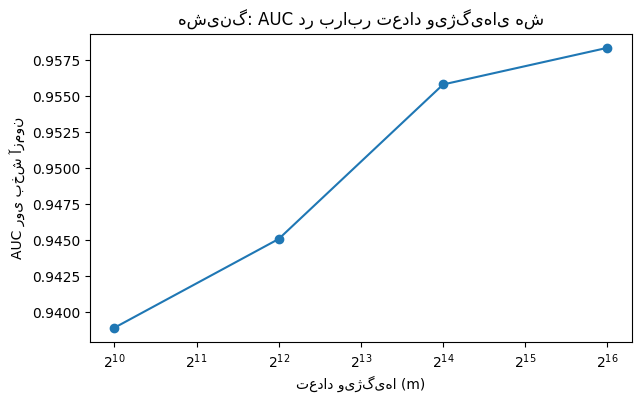

In [28]:
import matplotlib.pyplot as plt

ms = [m for m, auc in results]
aucs = [auc for m, auc in results]

plt.figure(figsize=(7,4))
plt.plot(ms, aucs, marker="o")
plt.xscale("log", base=2)
plt.xlabel("تعداد ویژگی‌ها (m)")
plt.ylabel("AUC روی بخش آزمون")
plt.title("هشینگ: AUC در برابر تعداد ویژگی‌های هش")
plt.show()


---

## ۶. Target encoding: فشرده‌سازی دسته‌ها با استفاده از برچسب (و تلهٔ نشت اطلاعات)

### ایدهٔ اصلی
هر دسته را با یک آمار از برچسب (شرطی بر آن دسته) جایگزین کنید.

برای رگرسیون:
$$
\text{TE}(c) \approx \mathbb{E}[y\mid x=c].
$$

یک برآوردگر هموارشده (smoothing) به صورت:
$$
\text{TE}_\alpha(c) = \frac{\sum_{i:x_i=c} y_i + \alpha \mu}{n_c + \alpha},
$$
که در آن $\mu$ میانگین کلی و $\alpha>0$ پارامتر جمع‌شدگی (shrinkage) است.

### ریسک نشت
اگر $\text{TE}(c)$ را با همان سطرهایی محاسبه کنید که در حال کُدگذاری‌شان هستید (به‌ویژه داخل cross-validation)، برچسب به ویژگی نشت می‌کند و عملکرد به‌صورت غیرواقعی خوب به نظر می‌رسد.

آموزشِ امن نیازمند **target encoding خارج از فولد** است:
- برای هر فولد، TE را روی فولدهای دیگر محاسبه کنید و روی فولدِ نگه‌داشته‌شده اعمال کنید.

این را با `diamonds.csv` و پیش‌بینی قیمت بر اساس `cut`، `color` و `clarity` نشان می‌دهیم.


In [29]:
diam_te = diam.copy()

X = diam_te.drop(columns=["price"])
y = diam_te["price"].values

cat_cols = ["cut", "color", "clarity"]
num_cols = [c for c in X.columns if c not in cat_cols]

X_cat = X[cat_cols].copy()
X_num = X[num_cols].copy()

X_train_cat, X_test_cat, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_cat, X_num, y, test_size=0.25, random_state=42
)


In [30]:
def target_encode_fit(df_cat, y, alpha=20.0):
    # محاسبهٔ میانگین‌های هموارشدهٔ هدف برای هر دسته در هر ستون.
    mu = float(np.mean(y))
    maps = {}
    for col in df_cat.columns:
        stats = pd.DataFrame({col: df_cat[col].values, "y": y})
        agg = stats.groupby(col)["y"].agg(["count", "mean"])
        enc = (agg["mean"] * agg["count"] + mu * alpha) / (agg["count"] + alpha)
        maps[col] = enc.to_dict()
    return maps, mu

def target_encode_apply(df_cat, maps, mu):
    out = pd.DataFrame(index=df_cat.index)
    for col in df_cat.columns:
        out[col + "_te"] = df_cat[col].map(maps[col]).fillna(mu).astype(float)
    return out

maps, mu = target_encode_fit(X_train_cat, y_train, alpha=50.0)
Xtr_te = target_encode_apply(X_train_cat, maps, mu)
Xte_te = target_encode_apply(X_test_cat, maps, mu)

Xtr = pd.concat([Xtr_te.reset_index(drop=True), X_train_num.reset_index(drop=True)], axis=1)
Xte = pd.concat([Xte_te.reset_index(drop=True), X_test_num.reset_index(drop=True)], axis=1)

reg = Ridge(alpha=1.0)
reg.fit(Xtr, y_train)
pred = reg.predict(Xte)

(mean_absolute_error(y_test, pred), r2_score(y_test, pred), Xtr.shape[1])


(np.float64(810.4586264501206), 0.8937561031532656, 10)

خروجیِ قبلی برای یک تقسیم train/test معتبر است (چون آمار فقط از بخش آموزش محاسبه شد).
اما برای cross-validation کافی نیست، مگر این‌که کُدگذاری را out-of-fold انجام دهید.

گام بعد: target encoding خارج از فولد.


In [31]:
def oof_target_encode(df_cat, y, n_splits=5, alpha=50.0, random_state=42):
    df_cat = df_cat.reset_index(drop=True)
    y = np.asarray(y)
    mu = float(np.mean(y))

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof = pd.DataFrame(index=np.arange(len(df_cat)))
    for col in df_cat.columns:
        oof[col + "_te"] = np.nan

    for train_idx, val_idx in kf.split(df_cat):
        df_tr, df_val = df_cat.iloc[train_idx], df_cat.iloc[val_idx]
        y_tr = y[train_idx]

        maps_fold, mu_fold = target_encode_fit(df_tr, y_tr, alpha=alpha)
        enc_val = target_encode_apply(df_val, maps_fold, mu_fold)

        oof.loc[val_idx, [c + "_te" for c in df_cat.columns]] = enc_val.values

    oof = oof.astype(float)

    maps_full, mu_full = target_encode_fit(df_cat, y, alpha=alpha)
    return oof, maps_full, mu_full

df_cat = X_train_cat.copy().reset_index(drop=True)
df_num = X_train_num.copy().reset_index(drop=True)
y_tr = y_train

oof_te, maps_full, mu_full = oof_target_encode(df_cat, y_tr, n_splits=5, alpha=50.0)

X_enc = pd.concat([oof_te, df_num], axis=1)
X_enc.head()


,cut_te,color_te,clarity_te,id,carat,depth,table,x,y,z
0,3939.408333,3159.618961,5024.964616,50585,0.70,59.5,56.0,5.79,5.81,3.45
1,3476.704758,5067.516281,3956.250275,17781,1.32,62.0,57.0,6.99,7.04,4.35
2,4583.762947,3905.978866,3250.632737,40989,0.45,61.4,61.0,4.95,4.89,3.02
3,3862.915819,5069.440490,3998.310188,20871,1.63,62.0,54.0,7.60,7.67,4.73
4,4567.051100,5067.516281,3341.862819,41299,0.51,59.4,60.0,5.26,5.21,3.11


In [32]:
# یک ارزیابی سریع با تقسیم روی ماتریس آموزشِ کُدگذاری‌شدهٔ out-of-fold
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_enc, y_tr, test_size=0.25, random_state=42)

reg = Ridge(alpha=1.0)
reg.fit(X_tr2, y_tr2)
pred = reg.predict(X_val2)

(mean_absolute_error(y_val2, pred), r2_score(y_val2, pred))


(np.float64(806.9206605068382), 0.8881253853563349)

### چک‌لیست عملی target encoding

1. TE را فقط با دادهٔ آموزش محاسبه کنید.
2. در CV، کُدگذاری را خارج از فولد انجام دهید.
3. از smoothing برای پایداری دسته‌های کم‌نمونه استفاده کنید.
4. برای سری‌زمانی یا داده‌های گروهی، فولدها باید ترتیب زمان یا مرز گروه را رعایت کنند.

Target encoding معمولاً وقتی می‌درخشد که کاردینالیته بالا باشد و one-hot خیلی بزرگ شود.


---

## ۷. ترکیب چند کُدگذار در یک گردش‌کار

در پروژه‌های واقعی اغلب چند نوع کُدگذار را با هم ترکیب می‌کنید:
- one-hot برای ستون‌های اسمیِ کوچک،
- hashing برای واژگان بزرگ یا پویا،
- ordinal برای دسته‌های واقعاً ترتیبی،
- target encoding برای دسته‌های پرکاردینال وقتی بتوانید قواعد ضدنشت را سخت‌گیرانه اجرا کنید.

یک طراحی ترکیبی را روی `Fast_Food_Restaurants_US.csv` نشان می‌دهیم:
- one-hot برای `province`,
- hashing برای `city`، `categories` و `name`,
- و یک طبقه‌بند خطی روی یک برچسب نمایشی (toy) برای نمایش مکانیک‌های انتها-به-انتها.


In [33]:
path_ff = "../../../Datasets/Classification/Fast_Food_Restaurants_US.csv"
ff = pd.read_csv(path_ff)

ff2 = ff.copy()
ff2["label_chain"] = ff2["name"].astype(str).str.contains(r"(?i)wendy|taco|sonic|arb(?:y|ies)|burger|mcdonald|kfc", regex=True).astype(int)

ff2 = ff2[["province","city","categories","name","label_chain"]].fillna("")
ff2.head()


,province,city,categories,name,label_chain
0,LA,Thibodaux,American Restaurant and Fast Food Restaurant,SONIC Drive In,1
1,LA,Thibodaux,Fast Food Restaurants,SONIC Drive In,1
2,TN,Pigeon Forge,Fast Food Restaurant,Taco Bell,1
3,TN,Pigeon Forge,Fast Food,Arby's,1
4,GA,Morrow,Fast Food Restaurant,Steak 'n Shake,0


In [34]:
def ff_row_to_dict(row):
    d = {}
    d[f"city={row['city']}"] = 1
    d[f"name={row['name']}"] = 1
    cats = str(row["categories"]).replace(" and ", ",").split(",")
    for c in cats:
        c = c.strip()
        if c:
            d[f"cat={c}"] = 1
    return d

X = ff2[["province","city","categories","name"]].copy()
y = ff2["label_chain"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [35]:
pre_ohe_prov = ColumnTransformer(
    transformers=[("prov", OneHotEncoder(handle_unknown="ignore"), ["province"])],
    remainder="drop"
)

hasher = FeatureHasher(n_features=2**13, input_type="dict")

train_dicts = X_train.apply(ff_row_to_dict, axis=1).tolist()
test_dicts = X_test.apply(ff_row_to_dict, axis=1).tolist()

Xh_train = hasher.transform(train_dicts)
Xh_test = hasher.transform(test_dicts)

Xp_train = pre_ohe_prov.fit_transform(X_train)
Xp_test = pre_ohe_prov.transform(X_test)

from scipy.sparse import hstack
X_train_all = hstack([Xp_train, Xh_train]).tocsr()
X_test_all = hstack([Xp_test, Xh_test]).tocsr()

X_train_all.shape


(7500, 8242)

In [36]:
clf = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=2000, random_state=42)
clf.fit(X_train_all, y_train)

proba = clf.predict_proba(X_test_all)[:, 1]
pred = (proba >= 0.5).astype(int)

accuracy_score(y_test, pred), roc_auc_score(y_test, proba)


(0.9932, np.float64(0.9992005818262308))

این الگو در صنعت بسیار رایج است:
- کُدگذاری بدون برخورد وقتی ممکن باشد،
- hashing برای فیلدهای رده‌ای با کاردینالیتهٔ بالا یا واژگان در حال رشد،
- نمایش‌های فشرده وقتی حافظه و تأخیر (latency) مهم است.

در ادامه، برخی دام‌های رایج و سپس یک چارچوب تصمیم‌گیری و تمرین‌های پیشنهادی را ارائه می‌کنیم.


---

## ۷.۵ دام‌های رایج و چک‌های دیباگ

حتی اگر کُدگذار مناسب را انتخاب کنید، در عمل مشکلاتی پیش می‌آید. چک‌های زیر از بسیاری از غافلگیری‌های بعدی جلوگیری می‌کند.

### دام A: انفجار کاردینالیته
قبل از انتخاب one-hot، تعداد دسته‌های یکتا را اندازه بگیرید:
$$
K_j = |\{x^{(i)}_j\}_{i=1}^n|.
$$
اگر $K_j$ بزرگ باشد (مثلاً هزاران)، و ستون به‌وضوح ترتیبی نباشد، hashing یا target encoding را در نظر بگیرید.

### دام B: دسته‌های نادر
دسته‌های بسیار کم‌تکرار، مخصوصاً برای مدل‌های خطی، می‌توانند مثل نویز عمل کنند.
راه‌حل استاندارد این است که دسته‌هایی با فراوانی زیر یک آستانه را *قبل از کُدگذاری* به `"Other"` تبدیل کنید.

### دام C: دسته‌های دیده‌نشده در زمان استقرار
اگر دادهٔ تولید شامل دسته‌های جدید باشد، خط لوله باید رفتار مشخصی داشته باشد:
- one-hot: نادیده گرفتن دسته‌های جدید،
- ordinal: نگاشت دسته‌های جدید به یک کُد رزرو (مثلاً -1)،
- hashing: به‌صورت طبیعی دسته‌های جدید را می‌پذیرد،
- target: نگاشت دسته‌های جدید به میانگین کلی $\mu$ (یا prior).

در ادامه یک ابزار کوچک برای ادغام دسته‌های نادر روی دیتاست فست‌فود پیاده‌سازی می‌کنیم.


In [37]:
def group_rare_categories(s, min_count=50, other_label="Other"):
    counts = s.value_counts(dropna=False)
    rare = counts[counts < min_count].index
    return s.where(~s.isin(rare), other_label)

# Example: city cardinality and rare grouping
city_counts = ff2["city"].value_counts()
print("Unique cities:", ff2["city"].nunique())
print("Top 10 cities:")
print(city_counts.head(10))

ff2_grouped = ff2.copy()
ff2_grouped["city_grouped"] = group_rare_categories(ff2_grouped["city"], min_count=30)

print("\nUnique cities after grouping:", ff2_grouped["city_grouped"].nunique())
print("Top 10 grouped cities:")
print(ff2_grouped["city_grouped"].value_counts().head(10))


Unique cities: 2764
Top 10 cities:
city
Houston        107
Las Vegas       82
Phoenix         78
Columbus        72
Dallas          66
Orlando         65
Los Angeles     64
Miami           62
Chicago         57
San Antonio     54
Name: count, dtype: int64

Unique cities after grouping: 35
Top 10 grouped cities:
city_grouped
Other          8363
Houston         107
Las Vegas        82
Phoenix          78
Columbus         72
Dallas           66
Orlando          65
Los Angeles      64
Miami            62
Chicago          57
Name: count, dtype: int64


---

## ۸. چارچوب تصمیم‌گیری: کدام کُدگذار را انتخاب کنیم؟

### ۸.۱ ابتدا معناشناسی را تطبیق دهید
- اگر دسته **ترتیب واقعی** دارد، ordinal encoding را با ترتیب صریح به‌کار ببرید.
- اگر دسته **اسمی** است، ترتیب تحمیل نکنید.

### ۸.۲ بُعد را کنترل کنید
اگر $K$ کاردینالیتهٔ یک ویژگی اسمی باشد:

- one-hot: بُعد با $K$ رشد می‌کند (دقیق و تفسیرپذیر).
- hashing: بُعد ثابت $m$ (تقریبی، همراه با برخورد).
- target encoding: بُعد ثابت ۱ برای هر ویژگی (قوی، اما حساس به نشت).

### ۸.۳ خانوادهٔ مدل را در نظر بگیرید

| خانوادهٔ مدل | کُدگذاری‌های رایج | چرا |
|---|---|---|
| خطی / GLM | one-hot، hashing، target | مدل‌های خطی از ویژگی‌های تُنُکِ پُربُعد سود می‌برند؛ TE واژگان بزرگ را فشرده می‌کند |
| مبتنی بر فاصله | one-hot (با دقت)، ordinal (فقط اگر ترتیب واقعی) | فاصله‌ها در فضای کُدگذاری‌شده مهم‌اند |
| درختی / GBDT | ordinal، one-hot، یا دسته‌بندیِ بومی (native) | درخت‌ها می‌توانند روی کُدهای عددی split بزنند، ولی پشتیبانی بومی اغلب بهتر است |

### ۸.۴ مدیریت دسته‌های جدید
- one-hot: `handle_unknown="ignore"`.
- ordinal: `unknown_value` با `handle_unknown="use_encoded_value"`.
- hashing: به‌صورت طبیعی دسته‌های جدید را پشتیبانی می‌کند.
- target: دسته‌های جدید را به میانگین کلی $\mu$ نگاشت کنید.

### ۸.۵ انضباط ضدنشت در target encoding
اگر کُدگذاری شما از برچسب استفاده می‌کند، باید طوری محاسبه شود که مقدار کُدگذاری هر سطر بدون استفاده از برچسب همان سطر تولید شود (out-of-fold).


---

## ۹. تمرین‌ها (پیشنهادی)

1. **one-hot با منظم‌سازی**: روی `drug200.csv` پارامتر `C` را برای logistic regression تنظیم کنید و تغییر دقت را بسنجید.
2. **ordinal در برابر one-hot**: روی `diamonds.csv` برای `cut/color/clarity` با Ridge و SGDRegressor مقایسه کنید.
3. **بُعد هش**: روی `airports.csv` مقدار `n_features` را (مثلاً $2^{10}$، $2^{12}$، $2^{14}$، $2^{16}$) تغییر دهید و AUC را رسم کنید.
4. **نمایش نشت**: target encoding نشتی داخل CV را پیاده‌سازی کنید و نشان دهید چرا عملکرد بیش‌برآورد می‌شود.
5. **ادغام دسته‌های نادر**: دسته‌هایی با فراوانی < 10 را به `"Other"` تبدیل کنید و بُعد one-hot و عملکرد مدل را مقایسه کنید.

اگر این تمرین‌ها را انجام دهید، از نظر عملی بر کُدگذاری ویژگی‌های رده‌ای در خط لوله‌های کلاسیک یادگیری ماشین مسلط خواهید شد.
